In [1]:
import colorsys
import maskingtools
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.ndimage as ndimage

In [2]:
# load images in
data_path = '/home/michaelneuder/research/imagequalityanalysis/nature_pics/'

In [3]:
pic_array = [mpimg.imread(os.path.join(data_path, 'file-{}.jpg'.format(ii))) / 255 for ii in range(1,51)]

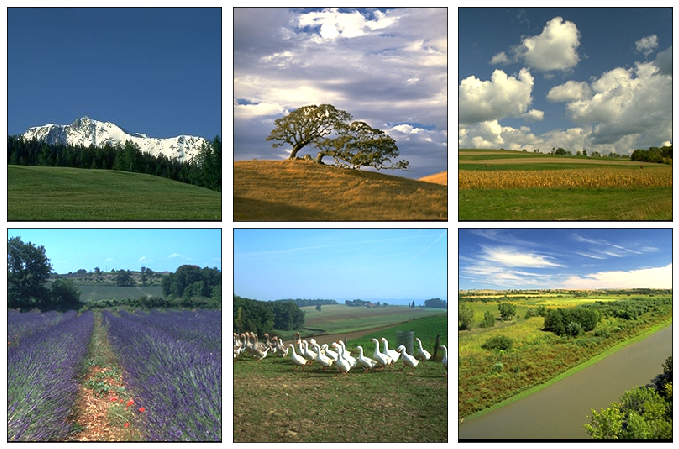

In [4]:
# data check
ax_dict = maskingtools.getImageGridAxes(rows=2, columns=3)
for ii in ax_dict:
    ax_dict[ii].imshow(pic_array[np.random.randint(1,50)])
plt.show()

In [5]:
# black and white images
pic_array = [maskingtools.rgbToBwImage(image) for image in pic_array]

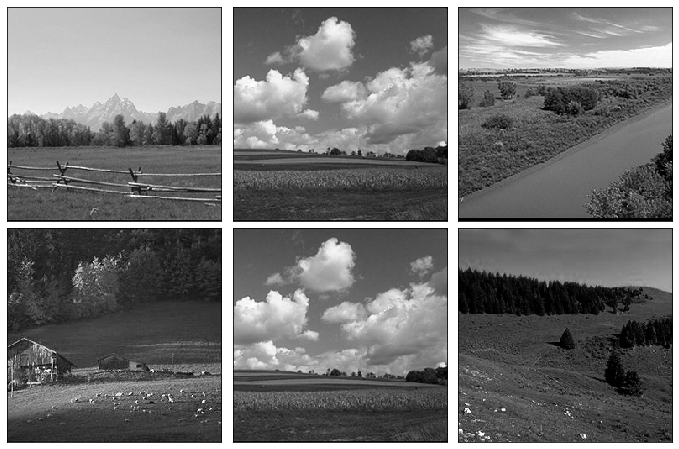

In [6]:
ax_dict = maskingtools.getImageGridAxes(rows=2, columns=3)
for ii in ax_dict:
    ax_dict[ii].imshow(pic_array[np.random.randint(1,50)], cmap='gray')
plt.savefig('bw_sanity.png')
plt.show()

In [7]:
# create a mask
def createMask(n=20, sigma=0):
    rows, cols = pic_array[0].shape
    mask = np.zeros((rows,cols))
    for ii in range(n):
        # zscore zscore -> random rotation -> gaussian blur
        mask += ndimage.gaussian_filter(
            np.rot90(
                maskingtools.zscore(
                    pic_array[np.random.randint(0,49)]
                ), np.random.choice([0,1,2,3]))
        , sigma=sigma)

    # map to [0,1]
    mask = maskingtools.uniform(mask)
    return mask

In [8]:
ax_dict = maskingtools.getImageGridAxes(rows=2, columns=3)
for ii in ax_dict:
    mask = createMask(sigma=2)
    ax_dict[ii].imshow(mask, cmap='gray')
plt.savefig('bw_masks.png')
plt.show()

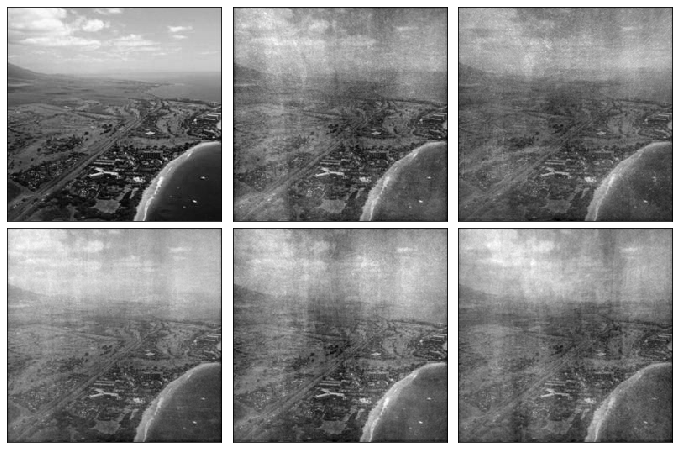

In [9]:
ax_dict = maskingtools.getImageGridAxes(rows=2, columns=3)
source = maskingtools.uniform(maskingtools.zscore(pic_array[np.random.randint(0,49)]))
ax_dict[0].imshow(source, cmap='gray')
for ii in range(1,6):
    mask = createMask(n=50,sigma=0)
    ax_dict[ii].imshow(maskingtools.uniform(source+mask), cmap='gray')
plt.savefig('bw_masksn25s10.png')
plt.show()

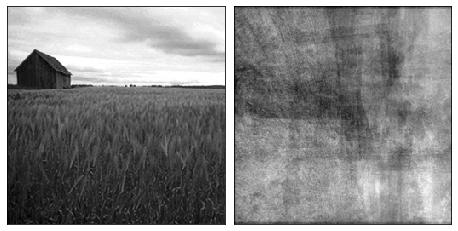

In [10]:
source = maskingtools.uniform(maskingtools.zscore(pic_array[np.random.randint(0,49)]))
mask = createMask(n=25,sigma=0)
ax_dict = maskingtools.getImageGridAxes(rows=1, columns=2)
ax_dict[0].imshow(source, cmap='gray')
ax_dict[1].imshow(mask, cmap='gray')
plt.show()

In [11]:
source.mean(), mask.mean()

(0.4534276531588647, 0.516886022838245)

In [12]:
source -= source.mean()
mask -= mask.mean()

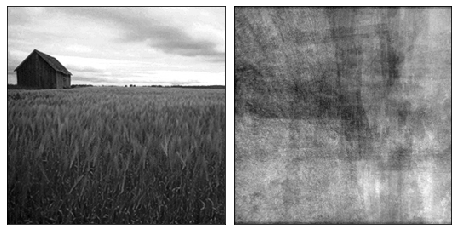

In [13]:
ax_dict = maskingtools.getImageGridAxes(rows=1, columns=2)
ax_dict[0].imshow(source, cmap='gray')
ax_dict[1].imshow(mask, cmap='gray')
plt.savefig('imgmask.png')
plt.show()

In [14]:
rows, cols = 256, 256

In [15]:
mpSource = (1/rows*cols) * sum((source.flatten() - source.mean())**2)
mpMask = (1/rows*cols) * sum((mask.flatten() - mask.mean())**2)

In [16]:
alphas = [0,0.1,0.25, 0.5, 0.75, 1]

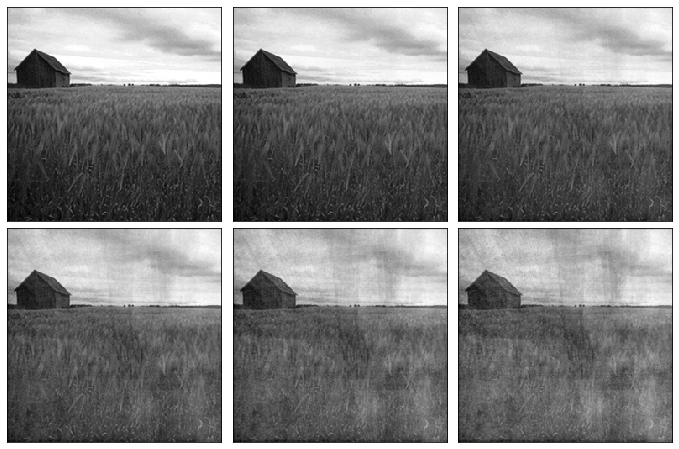

In [17]:
ax_dict = maskingtools.getImageGridAxes(rows=2, columns=3)
for ii in range(0,6):
    distorted = ((source - source.mean() / np.sqrt(mpSource)) + alphas[ii] * (mask - mask.mean() / np.sqrt(mpMask))) * np.sqrt(mpSource) + source.mean() 
    ax_dict[ii].imshow(distorted, cmap='gray')
plt.savefig('distortionalphas.png')
plt.show()

In [18]:
# ok couple of things. zscore again after mask addition. also we dont have to get so complicated with the addition
# it can simply be source + \alpha * mask

In [19]:
# create a mask ** new zscore addition
def createMask(n=20, sigma=0):
    rows, cols = pic_array[0].shape
    mask = np.zeros((rows,cols))
    for ii in range(n):
        # zscore -> random rotation -> gaussian blur
        mask += ndimage.gaussian_filter(
            np.rot90(
                maskingtools.zscore(
                    pic_array[np.random.randint(0,49)]
                ), np.random.choice([0,1,2,3]))
        , sigma=sigma)

    # zscore again to bring std. dev back to 1
    mask = maskingtools.zscore(mask)
    
    # map to [0,1]
    mask = maskingtools.uniform(mask)
    return mask

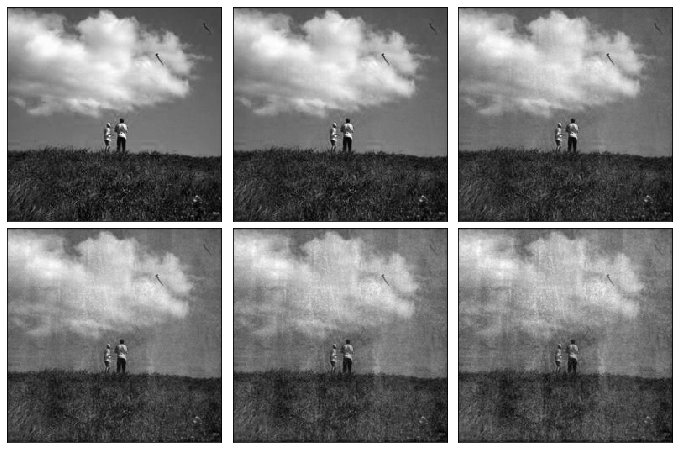

In [20]:
ax_dict = maskingtools.getImageGridAxes(rows=2, columns=3)
source = pic_array[np.random.randint(len(pic_array))]
mask = createMask(n=20, sigma=0)
for ii in range(0,6):
    distorted = source + alphas[ii] * mask
    ax_dict[ii].imshow(distorted, cmap='gray')
plt.savefig('distortionalphasnew.png')
plt.show()

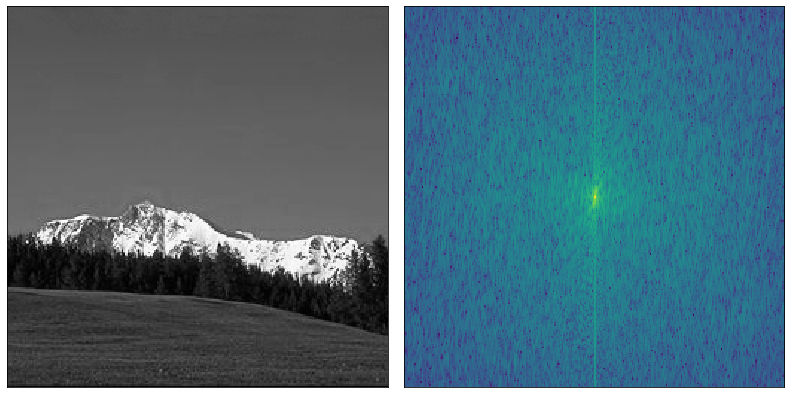

In [21]:
# fourier transforms
source = pic_array[np.random.randint(len(pic_array))]
f = np.fft.fft2(source)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

# show 
ax_dict = maskingtools.getImageGridAxes(rows=1, columns=2, im_size=7)

ax_dict[0].imshow(source, cmap='gray')
ax_dict[1].imshow(magnitude_spectrum)

plt.savefig('fourier.png')
plt.show()

In [22]:
source = pic_array[np.random.randint(len(pic_array))]
f = np.fft.fft2(source)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

rows, cols = source.shape
crow,ccol = int(rows/2) , int(cols/2)
width, height = 40, 40 
fshift[crow-height:crow+height, ccol-width:ccol+width] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

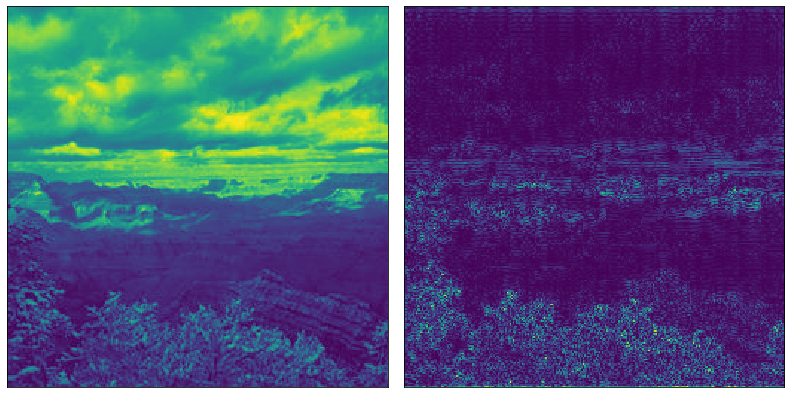

In [23]:
ax_dict = maskingtools.getImageGridAxes(rows=1, columns=2, im_size=7)

ax_dict[0].imshow(source)
ax_dict[1].imshow(img_back)

plt.savefig('fourier_back.png')
plt.show()

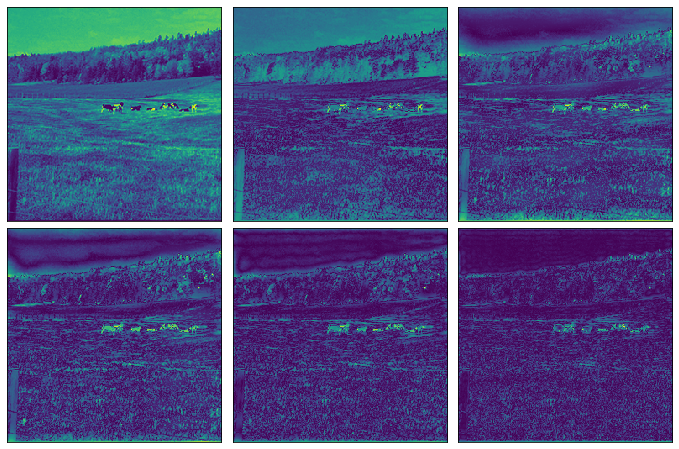

In [24]:
# removing different frequencies from center
source = pic_array[np.random.randint(len(pic_array))]
f = np.fft.fft2(source)
fshift = np.fft.fftshift(f)

rows, cols = source.shape
crow,ccol = int(rows/2) , int(cols/2)

widths = [0,1,3,5,10,20]

ax_dict = maskingtools.getImageGridAxes(rows=2, columns=3)

for ii in ax_dict:
    dim = widths[ii]
    fshift[crow-dim:crow+dim, ccol-dim:ccol+dim] = 0
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    ax_dict[ii].imshow(img_back)

plt.savefig('difffreqs.png')
plt.show()

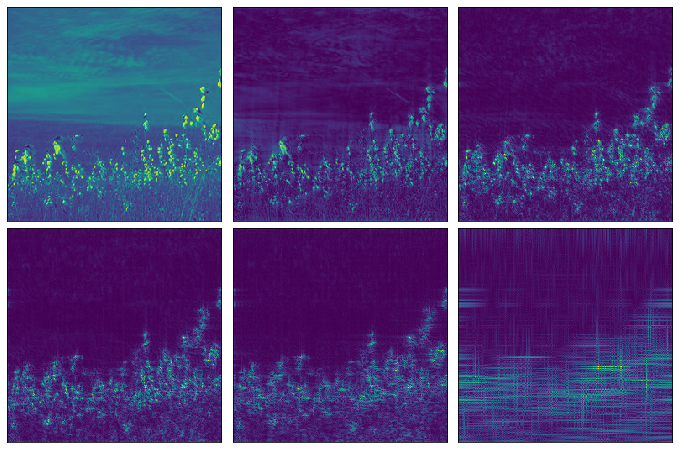

In [25]:
# removing different frequencies from edges
source = pic_array[np.random.randint(len(pic_array))]
f = np.fft.fft2(source)
fshift = np.fft.fftshift(f)

scale = 0
widths = np.asarray([0,130,150,175,200,250])

ax_dict = maskingtools.getImageGridAxes(rows=2, columns=3)

for ii in ax_dict:
    dim = widths[ii]
    fshift[0:dim, 0:dim] = 0
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    ax_dict[ii].imshow(img_back)

plt.savefig('difffreqs_high.png')
plt.show()

In [26]:
def lowFreqFilter(image, width):
    # fft
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # find center
    rows, cols = image.shape
    crow,ccol = int(rows/2) , int(cols/2)
    
    # remove rectangle 
    fshift[crow-width:crow+width, ccol-width:ccol+width] = 0
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

In [27]:
# adding fft filtering
def createMask(n=20, sigma=0):
    rows, cols = pic_array[0].shape
    mask = np.zeros((rows,cols))
    for ii in range(n):
        # zscore -> random rotation -> gaussian blur
        mask += lowFreqFilter(ndimage.gaussian_filter(
            np.rot90(
                maskingtools.zscore(
                    pic_array[np.random.randint(0,49)]
                ), np.random.choice([0,1,2,3]))
        , sigma=sigma), width=n*3)

    # zscore again to bring std. dev back to 1
    mask = maskingtools.zscore(mask)
    
    # map to [0,1]
    mask = maskingtools.uniform(mask)
    return mask

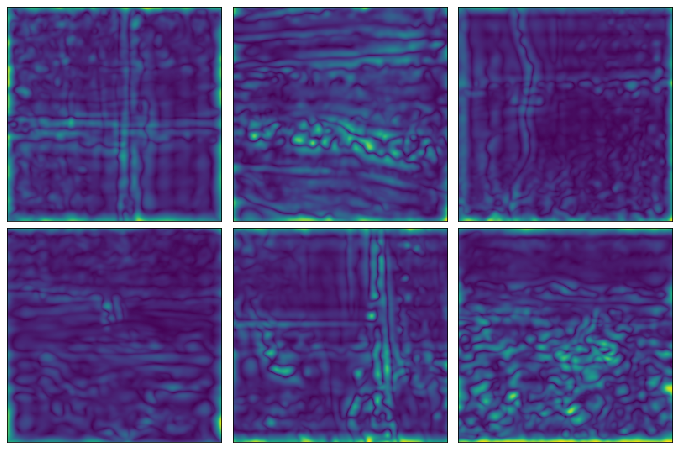

In [34]:
ax_dict = maskingtools.getImageGridAxes(rows=2, columns=3)

for ii in ax_dict:
    ax_dict[ii].imshow(createMask(n=2, sigma=3))

plt.savefig('lowfreqmasks_gb.png')
plt.show()

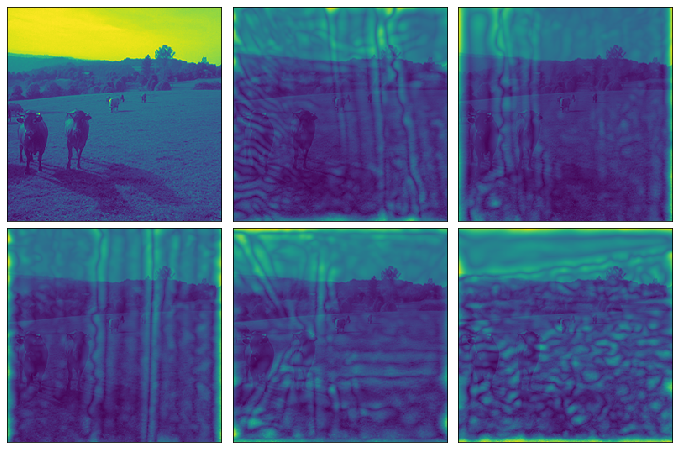

In [123]:
ax_dict = maskingtools.getImageGridAxes(rows=2, columns=3)

source = maskingtools.zscore(pic_array[np.random.randint(len(pic_array))])
ax_dict[0].imshow(source)
for ii in range(1,6):
    ax_dict[ii].imshow(source + 7*createMask(n=2, sigma=3))

# plt.savefig('distortionsfft.png')
plt.show()

In [36]:
source = pic_array[np.random.randint(len(pic_array))]
f = np.fft.fft2(source)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

rows, cols = source.shape
crow,ccol = int(rows/2) , int(cols/2)
width, height = 40, 40 
fshift[crow-height:crow+height, ccol-width:ccol+width] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

/home/michaelneuder/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


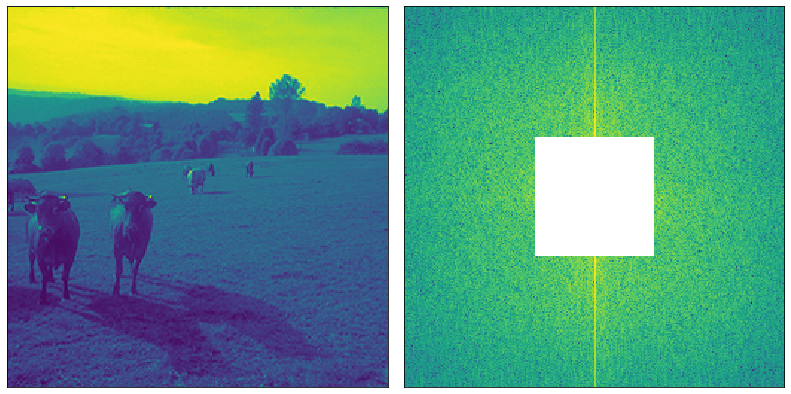

In [39]:
ax_dict = maskingtools.getImageGridAxes(rows=1, columns=2, im_size=7)

ax_dict[0].imshow(source)
ax_dict[1].imshow( 20*np.log(np.abs(fshift)))

plt.savefig('fourier_back.png')
plt.show()

In [35]:
def freqFilter(image, n, alpha, beta):
    # fft
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # find center
    rows, cols = image.shape
    crow,ccol = int(rows/2) , int(cols/2)
    
    width = int(rows / n)
    
    for ii in range(n):
        newFshift = fshift.copy()
        newFshift[crow-n*width : crow:n*width, ccol-n*width : ccol:n*width] = n
        # alpha * (1-np.exp(-1*beta * n))
        newFshift[crow-(n-1)*width : crow:(n-1)*width, ccol-(n-1)*width : ccol:(n-1)*width] = 
        fshift[crow-(n-1)*width : crow:(n-1)*width, ccol-(n-1)*width : ccol:(n-1)*width]
        fshift = newFshift
        
    # remove rectangle 
    fshift[crow-width:crow+width, ccol-width:ccol+width] = 0
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

In [ ]:
# adding fft filtering
def createMask(n=20, sigma=0):
    rows, cols = pic_array[0].shape
    mask = np.zeros((rows,cols))
    for ii in range(n):
        # zscore -> random rotation -> gaussian blur
        mask += lowFreqFilter(ndimage.gaussian_filter(
            np.rot90(
                maskingtools.zscore(
                    pic_array[np.random.randint(0,49)]
                ), np.random.choice([0,1,2,3]))
        , sigma=sigma), width=n*3)

    # zscore again to bring std. dev back to 1
    mask = maskingtools.zscore(mask)
    
    # map to [0,1]
    mask = maskingtools.uniform(mask)
    return mask

In [199]:
image = pic_array[np.random.randint(len(pic_array))]
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)
alpha = 1
beta = 0.3

# find center
rows, cols = image.shape
crow,ccol = int(rows/2) , int(cols/2)
n = 4
width = int(crow / n)

for ii in range(1,n+1):
    newFshift = fshift.copy()
    print(crow-ii*width , crow+ii*width, ccol-ii*width , ccol+ii*width)
    print(alpha * (1-np.exp(-1*beta * (ii-1))))
    newFshift[crow-ii*width : crow+ii*width, ccol-ii*width : ccol+ii*width] = alpha * (1-np.exp(-1*beta * (ii-1))) *\
    fshift[crow-ii*width : crow+ii*width, ccol-ii*width : ccol+ii*width]
    newFshift[crow-(ii-1)*width : crow+(ii-1)*width, ccol-(ii-1)*width : ccol+(ii-1)*width] =\
    fshift[crow-(ii-1)*width : crow+(ii-1)*width, ccol-(ii-1)*width : ccol+(ii-1)*width]
    fshift = newFshift.copy()

96 160 96 160
0.0
64 192 64 192
0.2591817793182821
32 224 32 224
0.4511883639059736
0 256 0 256
0.5934303402594008


/home/michaelneuder/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


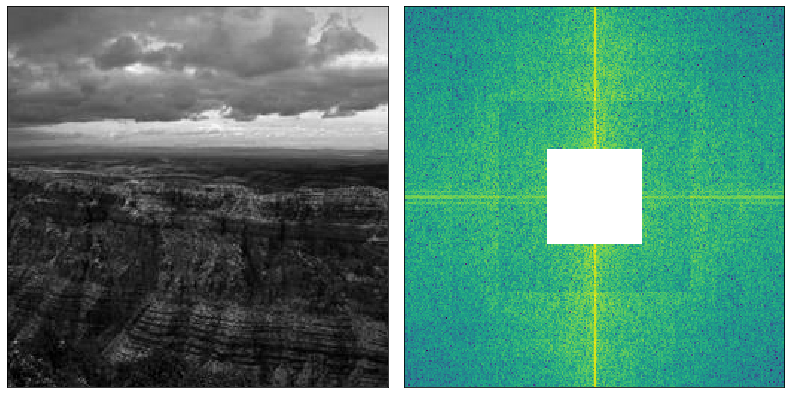

In [200]:
ax_dict = maskingtools.getImageGridAxes(rows=1, columns=2, im_size=7)

ax_dict[0].imshow(image, cmap='gray')
ax_dict[1].imshow( 20*np.log(np.abs(fshift)))

plt.savefig('fourier_ranges_mult_fix.png')
plt.show()